In [1]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 4.6 MB/s eta 0:00:00:00:0100:01


In [1]:
import pandas as pd
import numpy as np

import xgboost as xgb
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_curve, auc

In [2]:
def load_full_df():
    main_df = pd.read_csv("processed_wildfire_ERA5_FWI.csv",index_col=0)
    main_df['date'] = pd.to_datetime(main_df['date'])
    main_df.rename(columns={'latitude_ERA5': 'latitude', 'longitude_ERA5': 'longitude'},inplace=True)
    unnamed_cols = [col for col in main_df.columns if col.startswith('Unnamed:')]
    main_df.drop(columns=unnamed_cols, inplace=True)
    main_df['type_of_high_vegetation'] = main_df['type_of_high_vegetation'].astype(int)
    main_df['type_of_low_vegetation'] = main_df['type_of_low_vegetation'].astype(int)
    return main_df

def test_train_validation_split(validation_df, test_train_df, target_variable='fire', test_proportion=0.33):
    """
    Validation data is obtained by taking all data after a certain time. This is similar to model deployment.
    Train and test data are obtained using a stratified split
    """
    X_validation = validation_df.drop(columns={target_variable})
    y_validation = validation_df[target_variable]

    X_train, X_test, y_train, y_test = train_test_split(test_train_df.drop(columns={target_variable}), 
                                                        test_train_df[target_variable], 
                                                        test_size=test_proportion,
                                                        stratify=test_train_df[target_variable], 
                                                        random_state=42)
    
    return X_train, X_test, X_validation, y_train, y_test, y_validation

In [4]:
main_df = load_full_df()

# Create the validation dataframe out of data after 2019
validation_df = main_df[main_df['date'] > pd.Timestamp('2019-01-01')]
test_train_df = main_df[main_df['date'] < pd.Timestamp('2019-01-01')]

X_train, X_test, X_validation, y_train, y_test, y_validation = test_train_validation_split(validation_df, test_train_df, target_variable='fire', test_proportion=0.25)

In [5]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier

# Define features to include #
pass_features = ['leaf_area_index_high_vegetation', 'slope_of_sub_gridscale_orography']
categorical_features = ['type_of_high_vegetation']
numeric_features = ['DMC','global_noon_LST_2m_temperature','BUI',
                'FWI','latitude','FFMC','global_noon_LST_relative_humidity','24hr_max_temperature',
                'global_noon_LST_2m_temperature_1dayLag','global_noon_LST_2m_temperature_2dayLag',
                'high_vegetation_cover','24hr_max_temperature_1dayLag','low_vegetation_cover',
                '24hr_accumulated_precipitation']
####

# Define custom preprocessing functions. Put any custom functions in SVM_functions.py also so they are accessible by the ensemble
def extract_day_of_year(X):
    day_of_year = X['date'].dt.dayofyear.to_frame(name='day_of_the_year')
    return day_of_year

# Splitting the dataset into training and validation sets# Data Preprocessing Steps
date_transformer = ColumnTransformer(
    transformers=[
        ('date', FunctionTransformer(extract_day_of_year, validate=False), ['date'])
    ],
    verbose_feature_names_out=False,
    remainder='passthrough'
).set_output(transform='pandas')

scale = ColumnTransformer(
    transformers=[
        ('scale_transformer', StandardScaler(), numeric_features)
    ],
    verbose_feature_names_out=False
).set_output(transform='pandas')

cate = ColumnTransformer(
    transformers=[
        ('categorical_transformer', OneHotEncoder(sparse_output=False), categorical_features)
    ],
    verbose_feature_names_out=False
).set_output(transform='pandas')

pss = ColumnTransformer(
    transformers=[
        ('Pass_transformer', 'passthrough', pass_features)
    ],
    verbose_feature_names_out=False
).set_output(transform='pandas')

feature_union = FeatureUnion([
    ('numeric', scale),
    ('categorical', cate),
    ('pass', pss),
])

preprocessing_pipeline = Pipeline([
    ('day_of_year', date_transformer),
    ('feature_union', feature_union),
])

In [6]:
from joblib import dump

preprocessing_pipeline.fit(X_train)
dump(preprocessing_pipeline,'XGB_V2_pipeline.joblib')

['XGB_V2_pipeline.joblib']

In [16]:
# Pipeline Testing
#S1 = full_pipeline.named_steps['day_of_year'].fit_transform(X_train)
#S2 = full_pipeline.named_steps['feature_union'].fit_transform(S1)

In [14]:
# Apply preprocessing
X_train_preprocessed = preprocessing_pipeline.fit_transform(X_train)
X_test_preprocessed = preprocessing_pipeline.transform(X_test)
X_validation_preprocessed = preprocessing_pipeline.transform(X_validation)

# Create DMatrix for train and validation sets
dtrain = xgb.DMatrix(X_train_preprocessed, label=y_train)
dtest = xgb.DMatrix(X_test_preprocessed, label=y_test)
dvalidation = xgb.DMatrix(X_validation_preprocessed, label=y_validation)

In [7]:
import xgboost as xgb
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

# Define the parameter grid
param_grid = {
    'max_depth': [None, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_boost_round': [300, 400, 500]
}

# Function to perform grid search with verbose output
def manual_grid_search(dtrain, param_grid, ratio, folds=5):
    best_auc = 0
    best_params = {}
    best_num_boost_round = 0  # Variable to store the best number of boosting rounds
    for max_depth in param_grid['max_depth']:
        for learning_rate in param_grid['learning_rate']:
            for num_boost_round in param_grid['num_boost_round']:
                params = {
                    'objective': 'binary:logistic',
                    'scale_pos_weight': ratio,
                    'eval_metric': 'logloss',
                    'tree_method': 'hist',
                    'device': 'cuda',
                    'max_depth': max_depth,
                    'learning_rate': learning_rate,
                }
                # Perform k-fold cross validation
                cv_results = xgb.cv(params, dtrain, num_boost_round=num_boost_round, nfold=folds,
                                        metrics='auc', early_stopping_rounds=10, seed=42, verbose_eval=False)
                mean_auc = cv_results['test-auc-mean'].max()
                print(f"Mean AUC: {mean_auc} for params: {params}, num_boost_round = {num_boost_round}")
                if mean_auc > best_auc:
                    best_auc = mean_auc
                    best_params = params
                    best_num_boost_round = num_boost_round  # Update the best num_boost_round

    return best_params, best_auc, best_num_boost_round

# Calculate the ratio of negative to positive samples for scale_pos_weight
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

# Execute manual grid search
best_params, best_auc, best_num_boost_round = manual_grid_search(dtrain, param_grid, ratio)
print("Best parameters:", best_params)
print("Best num_boost_round",best_num_boost_round)
print("Best cross-validation AUC: {:.2f}".format(best_auc))

# Train the final model with the best parameters and the optimal number of boosting rounds
final_model = xgb.train(best_params, dtrain, num_boost_round=best_num_boost_round)
final_model.save_model('final_XGBoost_V2.json')
#GS1
#Best parameters: {'objective': 'binary:logistic', 'scale_pos_weight': 171.49972345132744, 'eval_metric': 'logloss', 'tree_method': 'hist', 'device': 'cuda', 'max_depth': 5, 'learning_rate': 0.1, 'num_boost_round': 400}
#Best cross-validation AUC: 0.86

#GS2
#Best parameters: {'objective': 'binary:logistic', 'scale_pos_weight': 171.49972345132744, 'eval_metric': 'logloss', 'tree_method': 'hist', 'device': 'cuda', 'max_depth': 5, 'learning_rate': 0.1}
#Best cross-validation AUC: 0.86

Mean AUC: 0.8332791055772905 for params: {'objective': 'binary:logistic', 'scale_pos_weight': 171.49972345132744, 'eval_metric': 'logloss', 'tree_method': 'hist', 'device': 'cuda', 'max_depth': None, 'learning_rate': 0.01}, num_boost_round = 300
Mean AUC: 0.8383826045979879 for params: {'objective': 'binary:logistic', 'scale_pos_weight': 171.49972345132744, 'eval_metric': 'logloss', 'tree_method': 'hist', 'device': 'cuda', 'max_depth': None, 'learning_rate': 0.01}, num_boost_round = 400
Mean AUC: 0.8429233608366161 for params: {'objective': 'binary:logistic', 'scale_pos_weight': 171.49972345132744, 'eval_metric': 'logloss', 'tree_method': 'hist', 'device': 'cuda', 'max_depth': None, 'learning_rate': 0.01}, num_boost_round = 500
Mean AUC: 0.85809216482452 for params: {'objective': 'binary:logistic', 'scale_pos_weight': 171.49972345132744, 'eval_metric': 'logloss', 'tree_method': 'hist', 'device': 'cuda', 'max_depth': None, 'learning_rate': 0.1}, num_boost_round = 300
Mean AUC: 0.8580921

In [7]:
import xgboost as xgb
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

# Calculate the ratio of negative to positive samples for scale_pos_weight
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

best_params = {
                'objective': 'binary:logistic',
                'scale_pos_weight': ratio,
                'eval_metric': 'logloss',
                'tree_method': 'hist',
                'device': 'cuda',
                'max_depth': 5,
                'learning_rate': 0.1,
            }

# Train the final model with the best parameters and the optimal number of boosting rounds
final_model = xgb.train(best_params, dtrain, num_boost_round=400)

In [9]:
# Optionally, you can save it to a JSON format (available in recent versions of XGBoost)
final_model.save_model('final_XGBoost.json')

In [9]:
# Load the model
loaded_model = xgb.XGBClassifier()
loaded_model.load_model('final_XGBoost_V2.json')

In [16]:
# Predictions
y_pred_proba = loaded_model.predict(X_validation_preprocessed)
y_pred = (y_pred_proba > 0.5).astype(int)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_validation, y_pred))

# Precision-Recall curve and AUC
precision, recall, thresholds = precision_recall_curve(y_validation, y_pred_proba)
pr_auc = auc(recall, precision)
print(f"Precision-Recall AUC: {pr_auc}")

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.86      0.92    179619
           1       0.02      0.66      0.04       752

    accuracy                           0.86    180371
   macro avg       0.51      0.76      0.48    180371
weighted avg       0.99      0.86      0.92    180371

Precision-Recall AUC: 0.3407547101084813


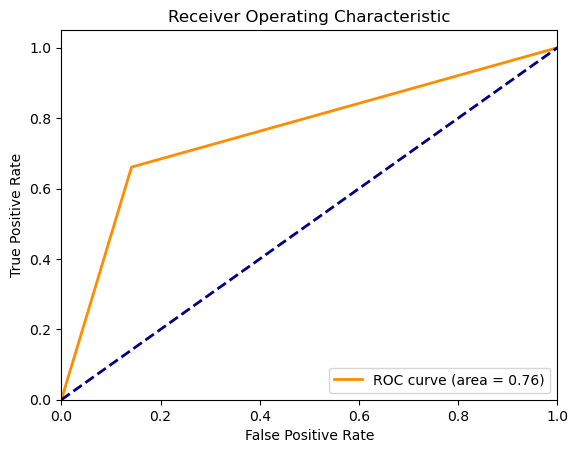

In [17]:
from Visualization_functions import plot_roc_curve, generate_visualizations

plot_roc_curve(y_validation,y_pred_proba)

In [20]:

generate_visualizations(X_validation,y_pred,y_validation,main_df,'XGB_V2_visuals')
